In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
import sklearn as skl
import torch 
seed_value = 420 
from numpy.random import seed
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
import itertools

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts() / norm_factor, hist.axes[0].edges, ax=axes, label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def truth_matching(reco, truth):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    pairs_2d = ak.cartesian({'reco':reco,'truth':truth})
    id_pairs_2d = ak.cartesian({'reco':reco,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(truth[0]), axis=1)

    deltars = pairs_3d['reco'].deltaR(pairs_3d['truth'])
    min_deltars = np.min(deltars, axis=2)
    id_pairs_3d = id_pairs_3d[(deltars == min_deltars)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]

    return id_pairs_3d

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    ax[1,1].hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    ax[1,1].hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    ax[1,1].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    ax[1,1].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    ax[1,1].set_xlabel(xlabel) # write x-axis label
    ax[1,1].set_ylabel("Arbitrary units") # write y-axis label
    ax[1,1].legend() # add legend

## Extracting Data

In [3]:
tree4 = uproot.open(directory + "4tops_withtruth_oct24.root")
events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_4t_neutrinos = tree4["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_4t_truth = tree4['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_4t_truth = events_4t_truth[(events_4t_truth['Particle.Status']==23)]

events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 105.7E-3

jets_pt_4t = events_4t_jets['Jet.PT'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_eta_4t = events_4t_jets['Jet.Eta'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_phi_4t = events_4t_jets['Jet.Phi'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_mass_4t = events_4t_jets['Jet.Mass'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]

electrons_pt_4t = events_4t_electrons['Electron.PT'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_eta_4t = events_4t_electrons['Electron.Eta'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_phi_4t = events_4t_electrons['Electron.Phi'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_mass_4t = events_4t_electrons['Electron.Mass'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]

muons_pt_4t = events_4t_muons['Muon.PT'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_eta_4t = events_4t_muons['Muon.Eta'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_phi_4t = events_4t_muons['Muon.Phi'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_mass_4t = events_4t_muons['Muon.Mass'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]

reco_pt_4t = ak.concatenate((jets_pt_4t,electrons_pt_4t,muons_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jets_eta_4t,electrons_eta_4t,muons_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jets_phi_4t,electrons_phi_4t,muons_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jets_mass_4t,electrons_mass_4t,muons_mass_4t), axis=1)

truth_pt_4t = events_4t_truth['Particle.PT']
truth_eta_4t = events_4t_truth['Particle.Eta']
truth_phi_4t = events_4t_truth['Particle.Phi']
truth_mass_4t = events_4t_truth['Particle.Mass']

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

### Partonic arrays

In [4]:
reco_4t_test = reco_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]
truth_4t_test = truth_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]

truth_4t_12 = truth_4t[ak.num(truth_4t)==12]
reco_4t_12 = reco_4t[ak.num(truth_4t)==12]

truth_4t_13 = truth_4t[ak.num(truth_4t)==13]
truth_4t_13 = truth_4t_13[:,1:]
reco_4t_13 = reco_4t[ak.num(truth_4t)==13]

truth_4t_test = ak.concatenate((truth_4t_12, truth_4t_13))
reco_4t_test = ak.concatenate((reco_4t_12, reco_4t_13))

id_pairs_4t = truth_matching(reco_4t_test, truth_4t_test)

top_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==1)|(id_pairs_4t['id']==5)|(id_pairs_4t['id']==9)]
top_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==2)|(id_pairs_4t['id']==6)|(id_pairs_4t['id']==10)]
antitop_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==3)|(id_pairs_4t['id']==7)|(id_pairs_4t['id']==11)]
antitop_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==4)|(id_pairs_4t['id']==8)|(id_pairs_4t['id']==12)]

top_1_particles_4t_temp = top_1_particles_4t[(ak.num(top_1_particles_4t, axis=2)!=0)]
top_2_particles_4t_temp = top_2_particles_4t[(ak.num(top_2_particles_4t, axis=2)!=0)]
antitop_1_particles_4t_temp = antitop_1_particles_4t[(ak.num(antitop_1_particles_4t, axis=2)!=0)]
antitop_2_particles_4t_temp = antitop_2_particles_4t[(ak.num(antitop_2_particles_4t, axis=2)!=0)]

top_1_particles_4t = top_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
top_2_particles_4t = top_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_1_particles_4t = antitop_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_2_particles_4t = antitop_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]

top_1_4t = ak.flatten(np.sum(top_1_particles_4t, axis=1))
top_2_4t = ak.flatten(np.sum(top_2_particles_4t, axis=1))
antitop_1_4t = ak.flatten(np.sum(antitop_1_particles_4t, axis=1))
antitop_2_4t = ak.flatten(np.sum(antitop_2_particles_4t, axis=1))

In [5]:
tree3j = uproot.open(directory + "tttj_skimmed_2810_withtruth_0.root")
events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tj_neutrinos = tree3j["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tj_truth = tree3j['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tj_truth = events_3tj_truth[(events_3tj_truth['Particle.Status']==23)]

events_3tj_electrons['Electron.Mass'] = np.ones_like(events_3tj_electrons['Electron.PT']) * 0.511E-3
events_3tj_muons['Muon.Mass'] = np.ones_like(events_3tj_muons['Muon.PT']) * 105.7E-3

jets_pt_3tj = events_3tj_jets['Jet.PT'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_eta_3tj = events_3tj_jets['Jet.Eta'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_phi_3tj = events_3tj_jets['Jet.Phi'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_mass_3tj = events_3tj_jets['Jet.Mass'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]

electrons_pt_3tj = events_3tj_electrons['Electron.PT'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tj = events_3tj_electrons['Electron.Eta'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tj = events_3tj_electrons['Electron.Phi'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tj = events_3tj_electrons['Electron.Mass'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tj = events_3tj_muons['Muon.PT'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_eta_3tj = events_3tj_muons['Muon.Eta'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_phi_3tj = events_3tj_muons['Muon.Phi'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_mass_3tj = events_3tj_muons['Muon.Mass'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]

reco_pt_3tj = ak.concatenate((jets_pt_3tj,electrons_pt_3tj,muons_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jets_eta_3tj,electrons_eta_3tj,muons_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jets_phi_3tj,electrons_phi_3tj,muons_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jets_mass_3tj,electrons_mass_3tj,muons_mass_3tj), axis=1)

truth_pt_3tj = events_3tj_truth['Particle.PT']
truth_eta_3tj = events_3tj_truth['Particle.Eta']
truth_phi_3tj = events_3tj_truth['Particle.Phi']
truth_mass_3tj = events_3tj_truth['Particle.Mass']

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]
truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]

In [6]:
truth_3tj_test = truth_3tj[ak.num(truth_3tj)==10]
reco_3tj_test = reco_3tj[ak.num(truth_3tj)==10]

id_pairs_3tj = truth_matching(reco_3tj_test, truth_3tj_test)

jet_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==1)]
top_1_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==2)|(id_pairs_3tj['id']==5)|(id_pairs_3tj['id']==6)]
top_2_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==3)|(id_pairs_3tj['id']==7)|(id_pairs_3tj['id']==8)]
top_3_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==4)|(id_pairs_3tj['id']==9)|(id_pairs_3tj['id']==10)]

jet_3tj = jet_3tj[ak.num(jet_3tj, axis=2)!=0]
top_1_particles_3tj_temp = top_1_particles_3tj[ak.num(top_1_particles_3tj, axis=2)!=0]
top_2_particles_3tj_temp = top_2_particles_3tj[ak.num(top_2_particles_3tj, axis=2)!=0]
top_3_particles_3tj_temp = top_3_particles_3tj[ak.num(top_3_particles_3tj, axis=2)!=0]

top_1_particles_3tj = top_1_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_2_particles_3tj = top_2_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_3_particles_3tj = top_3_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]

top_1_3tj = ak.flatten(np.sum(top_1_particles_3tj, axis=1))
top_2_3tj = ak.flatten(np.sum(top_2_particles_3tj, axis=1))
top_3_3tj = ak.flatten(np.sum(top_3_particles_3tj, axis=1))

In [7]:
tree3W = uproot.open(directory + "tttW_skim_with_truth_2810_0.root")
events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tW_neutrinos = tree3W["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tW_truth = tree3W['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tW_truth = events_3tW_truth[(events_3tW_truth['Particle.Status']==23)]

events_3tW_electrons['Electron.Mass'] = np.ones_like(events_3tW_electrons['Electron.PT']) * 0.511E-3
events_3tW_muons['Muon.Mass'] = np.ones_like(events_3tW_muons['Muon.PT']) * 105.7E-3

jets_pt_3tW = events_3tW_jets['Jet.PT'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_eta_3tW = events_3tW_jets['Jet.Eta'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_phi_3tW = events_3tW_jets['Jet.Phi'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_mass_3tW = events_3tW_jets['Jet.Mass'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]

electrons_pt_3tW = events_3tW_electrons['Electron.PT'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tW = events_3tW_electrons['Electron.Eta'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tW = events_3tW_electrons['Electron.Phi'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tW = events_3tW_electrons['Electron.Mass'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tW = events_3tW_muons['Muon.PT'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_eta_3tW = events_3tW_muons['Muon.Eta'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_phi_3tW = events_3tW_muons['Muon.Phi'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_mass_3tW = events_3tW_muons['Muon.Mass'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]

reco_pt_3tW = ak.concatenate((jets_pt_3tW,electrons_pt_3tW,muons_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jets_eta_3tW,electrons_eta_3tW,muons_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jets_phi_3tW,electrons_phi_3tW,muons_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jets_mass_3tW,electrons_mass_3tW,muons_mass_3tW), axis=1)

truth_pt_3tW = events_3tW_truth['Particle.PT']
truth_eta_3tW = events_3tW_truth['Particle.Eta']
truth_phi_3tW = events_3tW_truth['Particle.Phi']
truth_mass_3tW = events_3tW_truth['Particle.Mass']

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]
truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]

In [8]:
reco_3tW_test = reco_3tW[ak.num(truth_3tW)==11]
truth_3tW_test = truth_3tW[ak.num(truth_3tW)==11]

In [9]:
id_pairs_3tW = truth_matching(reco_3tW_test, truth_3tW_test)

top_1_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==1)|(id_pairs_3tW['id']==5)|(id_pairs_3tW['id']==9)]
top_2_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==2)|(id_pairs_3tW['id']==6)|(id_pairs_3tW['id']==10)]
top_3_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==3)|(id_pairs_3tW['id']==7)|(id_pairs_3tW['id']==11)]
W_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==4)|(id_pairs_3tW['id']==8)]

top_1_particles_3tW_temp = top_1_particles_3tW[ak.num(top_1_particles_3tW, axis=2)!=0]
top_2_particles_3tW_temp = top_2_particles_3tW[ak.num(top_2_particles_3tW, axis=2)!=0]
top_3_particles_3tW_temp = top_3_particles_3tW[ak.num(top_3_particles_3tW, axis=2)!=0]
W_3tW = W_3tW[ak.num(W_3tW, axis=2)!=0]

top_1_particles_3tW = top_1_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_2_particles_3tW = top_2_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_3_particles_3tW = top_3_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]

top_1_3tW = ak.flatten(np.sum(top_1_particles_3tW, axis=1))
top_2_3tW = ak.flatten(np.sum(top_2_particles_3tW, axis=1))
top_3_3tW = ak.flatten(np.sum(top_3_particles_3tW, axis=1))

In [10]:
tops_pt_4t = np.transpose(np.vstack(((top_1_4t.pt,top_2_4t.pt,antitop_1_4t.pt,antitop_2_4t.pt))))
tops_eta_4t = np.transpose(np.vstack(((top_1_4t.eta,top_2_4t.eta,antitop_1_4t.eta,antitop_2_4t.eta))))
tops_phi_4t = np.transpose(np.vstack(((top_1_4t.phi,top_2_4t.phi,antitop_1_4t.phi,antitop_2_4t.phi))))
tops_mass_4t = np.transpose(np.vstack(((top_1_4t.m,top_2_4t.m,antitop_1_4t.m,antitop_2_4t.m))))

top_1_3t = ak.concatenate((top_1_3tj,top_1_3tW))
top_2_3t = ak.concatenate((top_2_3tj,top_2_3tW))
top_3_3t = np.concatenate((top_3_3tj,top_3_3tW))

tops_pt_3t = np.transpose(np.vstack(((top_1_3t.pt,top_2_3t.pt,top_3_3t.pt))))
tops_eta_3t = np.transpose(np.vstack(((top_1_3t.eta,top_2_3t.eta,top_3_3t.eta))))
tops_phi_3t = np.transpose(np.vstack(((top_1_3t.phi,top_2_3t.phi,top_3_3t.phi))))
tops_mass_3t = np.transpose(np.vstack(((top_1_3t.m,top_2_3t.m,top_3_3t.m))))


tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':tops_mass_4t})
tops_3t = vector.zip({'pt':tops_pt_3t,'eta':tops_eta_3t,'phi':tops_phi_3t, 'mass':tops_mass_3t})

In [11]:
print(len(tops_4t))
print(len(tops_3t))

54820
21989


In [12]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

### Final-state arrays

In [92]:
leptons_pt_4t = ak.concatenate((electrons_pt_4t,muons_pt_4t), axis=1)
leptons_eta_4t = ak.concatenate((electrons_eta_4t,muons_eta_4t), axis=1)
leptons_phi_4t = ak.concatenate((electrons_phi_4t,muons_phi_4t), axis=1)
leptons_mass_4t = ak.concatenate((electrons_mass_4t,muons_mass_4t), axis=1)

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'mass':jets_mass_4t})
leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'mass':leptons_mass_4t})
all_products_4t = ak.concatenate((jets_4t,leptons_4t), axis=1)

In [93]:
print(len(jets_4t))
print(len(leptons_4t))

300000
300000


In [102]:
leptons_pt_3tW = ak.concatenate([electrons_pt_3tW,muons_pt_3tW],axis=1)
leptons_eta_3tW = ak.concatenate([electrons_eta_3tW,muons_eta_3tW],axis=1)
leptons_phi_3tW = ak.concatenate([electrons_phi_3tW,muons_phi_3tW],axis=1)
leptons_mass_3tW = ak.concatenate([electrons_mass_3tW,muons_mass_3tW],axis=1)

leptons_pt_3tj = ak.concatenate([electrons_pt_3tj,muons_pt_3tj],axis=1)
leptons_eta_3tj = ak.concatenate([electrons_eta_3tj,muons_eta_3tj],axis=1)
leptons_phi_3tj = ak.concatenate([electrons_phi_3tj,muons_phi_3tj],axis=1)
leptons_mass_3tj = ak.concatenate([electrons_mass_3tj,muons_mass_3tj],axis=1)

leptons_pt_3t = ak.concatenate([leptons_pt_3tW,leptons_pt_3tj])
leptons_eta_3t = ak.concatenate([leptons_eta_3tW,leptons_eta_3tj])
leptons_phi_3t = ak.concatenate([leptons_phi_3tW,leptons_phi_3tj])
leptons_mass_3t = ak.concatenate([leptons_mass_3tW,leptons_mass_3tj])

jets_pt_3t = ak.concatenate([jets_pt_3tW,jets_pt_3tj])
jets_eta_3t = ak.concatenate([jets_eta_3tW,jets_eta_3tj])
jets_phi_3t = ak.concatenate([jets_phi_3tW,jets_phi_3tj])
jets_mass_3t = ak.concatenate([jets_mass_3tW,jets_mass_3tj])

leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'mass':leptons_mass_3t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'mass':jets_mass_3t})
all_products_3t = ak.concatenate((jets_3t,leptons_3t), axis=1)

In [103]:
print(len(jets_3t))
print(len(leptons_3t))

50000
50000


In [104]:
filtered_jets_3t = jets_3t[(ak.num(leptons_3t)>=2) & (ak.num(jets_3t)>=3)]
filtered_leptons_3t = leptons_3t[(ak.num(jets_3t)>=3) & (ak.num(leptons_3t)>=2)]
jets_3t = filtered_jets_3t
leptons_3t = filtered_leptons_3t
filtered_jets_4t = jets_4t[(ak.num(leptons_4t)>=2) & (ak.num(jets_4t)>=3)]
filtered_leptons_4t = leptons_4t[(ak.num(jets_4t)>=3) & (ak.num(leptons_4t)>=2)]
jets_4t = filtered_jets_4t
leptons_4t = filtered_leptons_4t

In [105]:
print(len(jets_4t))
print(len(jets_3t))
print(len(leptons_4t))
print(len(leptons_3t))

20887
2916
20887
2916


## Sorting

### Final State Particles

In [59]:
sorted_indices = np.argsort(jets_4t.rho)
trans_sorted_4t = jets_4t[sorted_indices]

highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
#third_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':trans_sorted_4t.m[:,-3]})
#lowest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.rho)
trans_sorted_3t = jets_3t[sorted_indices]

highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
#third_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':trans_sorted_3t.m[:,-3]})
#lowest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(jets_4t.eta)
trans_sorted_4t = jets_4t[sorted_indices]

highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
#third_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':trans_sorted_4t.m[:,-3]})
#lowest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.eta)
trans_sorted_3t = jets_3t[sorted_indices]

highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
#third_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':trans_sorted_3t.m[:,-3]})
#lowest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})#

sorted_indices = np.argsort(jets_4t.phi)
trans_sorted_4t = jets_4t[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
#third_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':trans_sorted_4t.m[:,-3]})
#lowest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.phi)
trans_sorted_3t = jets_3t[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
#third_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':trans_sorted_3t.m[:,-3]})
#lowest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(jets_4t.phi)
trans_sorted_4t = jets_4t[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})
#third_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-3],'eta':trans_sorted_4t.eta[:,-3],'phi':trans_sorted_4t.phi[:,-3], 'mass':trans_sorted_4t.m[:,-3]})
#lowest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(jets_3t.phi)
trans_sorted_3t = jets_3t[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})
#third_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-3],'eta':trans_sorted_3t.eta[:,-3],'phi':trans_sorted_3t.phi[:,-3], 'mass':trans_sorted_3t.m[:,-3]})
#lowest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(leptons_4t.rho)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_pt_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
#lowest_pt_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.rho)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_pt_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
#lowest_pt_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(leptons_4t.eta)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_eta_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
#lowest_eta_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.eta)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_eta_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
#lowest_eta_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

sorted_indices = np.argsort(leptons_4t.phi)
trans_sorted_4t = leptons_4t[sorted_indices]

highest_phi_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
#lowest_phi_lepton_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':trans_sorted_4t.m[:,0]})

sorted_indices = np.argsort(leptons_3t.phi)
trans_sorted_3t = leptons_3t[sorted_indices]

highest_phi_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
#lowest_phi_lepton_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':trans_sorted_3t.m[:,0]})

IndexError: cannot slice ListArray (of length 300000) with array(-2): index out of range while attempting to get index -2 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-39/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_next_at.cpp#L21)

This error occurred while attempting to slice

    <Array [[29, 43.6, 61.4, ..., 188, 190], ...] type='300000 * var * float32'>

with

    (:, -2)

### Partonic

In [ ]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

In [ ]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [ ]:
jets_4t_total_4 = np.sum(jets_4t, axis=1)
jets_4t_H_t = np.sum(jets_4t.pt, axis=1)
jets_pt_balance_4t = jets_4t_total_4.pt/jets_4t_H_t

leptons_4t_total_4 = np.sum(leptons_4t, axis=1)
leptons_4t_H_t = np.sum(leptons_4t.pt, axis=1)
leptons_pt_balance_4t = leptons_4t_total_4.pt/leptons_4t_H_t

jets_3t_total_4 = np.sum(jets_3t, axis=1)
jets_3t_H_t = np.sum(jets_3t.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

leptons_3t_total_4 = np.sum(leptons_3t, axis=1)
leptons_3t_H_t = np.sum(leptons_3t.pt, axis=1)
leptons_pt_balance_3t = leptons_3t_total_4.pt/leptons_3t_H_t

total_4_3t = np.sum(all_products_3t, axis=1)
H_t_3t = np.sum(all_products_3t.pt, axis=1)
pt_balance_3t = total_4_3t.pt/H_t_3t

total_4_4t = np.sum(all_products_4t, axis=1)
H_t_4t = np.sum(all_products_4t.pt, axis=1)
pt_balance_4t = total_4_4t.pt/H_t_4t

sum_pt_jets_3t = np.sum(jets_3t.pt, axis=1)

S_xy_jets_3t = np.zeros((len(jets_3t),2,2))


S_xy_jets_3t[:,0,0] = np.sum(jets_3t.px**2/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((jets_3t.px*jets_3t.py)/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(jets_3t.py**2/ jets_3t.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(jets_4t.pt, axis=1)

S_xy_jets_4t = np.zeros((len(jets_4t),2,2))


S_xy_jets_4t[:,0,0] = np.sum(jets_4t.px**2/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((jets_4t.px*jets_4t.py)/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(jets_4t.py**2/ jets_4t.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

sum_pt_leptons_3t = np.sum(leptons_3t.pt, axis=1)

S_xy_leptons_3t = np.zeros((len(leptons_3t),2,2))

S_xy_leptons_3t[:,0,0] = np.sum(leptons_3t.px**2/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,0,1] = np.sum((leptons_3t.px*leptons_3t.py)/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,1,0] = S_xy_leptons_3t[:,0,1]
S_xy_leptons_3t[:,1,1] = np.sum(leptons_3t.py**2/ leptons_3t.pt, axis=1)


S_xy_leptons_3t = S_xy_leptons_3t/sum_pt_leptons_3t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t = np.linalg.eigvalsh(S_xy_leptons_3t)

sphericity_leptons_3t = 2*np.min(eigenvalues_leptons_3t, axis=1)/np.sum(eigenvalues_leptons_3t, axis=1)

sum_pt_leptons_4t = np.sum(leptons_4t.pt, axis=1)

S_xy_leptons_4t = np.zeros((len(leptons_4t),2,2))


S_xy_leptons_4t[:,0,0] = np.sum(leptons_4t.px**2/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,0,1] = np.sum((leptons_4t.px*leptons_4t.py)/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,1,0] = S_xy_leptons_4t[:,0,1]
S_xy_leptons_4t[:,1,1] = np.sum(leptons_4t.py**2/ leptons_4t.pt, axis=1)


S_xy_leptons_4t = S_xy_leptons_4t/sum_pt_leptons_4t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t = np.linalg.eigvalsh(S_xy_leptons_4t)

sphericity_leptons_4t = 2*np.min(eigenvalues_leptons_4t, axis=1)/np.sum(eigenvalues_leptons_4t, axis=1)

sum_pt_all_3t = np.sum(all_products_3t.pt, axis=1)

S_all_3t = np.zeros((len(all_products_3t),2,2))


S_all_3t[:,0,0] = np.sum(all_products_3t.px**2/ all_products_3t.pt, axis=1)
S_all_3t[:,0,1] = np.sum((all_products_3t.px*all_products_3t.py)/ all_products_3t.pt, axis=1)
S_all_3t[:,1,0] = S_all_3t[:,0,1]
S_all_3t[:,1,1] = np.sum(all_products_3t.py**2/ all_products_3t.pt, axis=1)


S_all_3t = S_all_3t/sum_pt_all_3t[:,np.newaxis,np.newaxis]

eigenvalues_all_3t = np.linalg.eigvalsh(S_all_3t)

sphericity_all_3t = 2*np.min(eigenvalues_all_3t, axis=1)/np.sum(eigenvalues_all_3t, axis=1)

sum_pt_all_4t = np.sum(all_products_4t.pt, axis=1)

S_all_4t = np.zeros((len(all_products_4t),2,2))


S_all_4t[:,0,0] = np.sum(all_products_4t.px**2/ all_products_4t.pt, axis=1)
S_all_4t[:,0,1] = np.sum((all_products_4t.px*all_products_4t.py)/ all_products_4t.pt, axis=1)
S_all_4t[:,1,0] = S_all_4t[:,0,1]
S_all_4t[:,1,1] = np.sum(all_products_4t.py**2/ all_products_4t.pt, axis=1)


S_all_4t = S_all_4t/sum_pt_all_4t[:,np.newaxis,np.newaxis]

eigenvalues_all_4t = np.linalg.eigvalsh(S_all_4t)

sphericity_all_4t = 2*np.min(eigenvalues_all_4t, axis=1)/np.sum(eigenvalues_all_4t, axis=1)

In [ ]:
jets_4t_invariant_mass = jets_4t_total_4.m
jets_4t_sum_indiv_inv_mass = np.sum(jets_4t.m,axis=1)
jets_4t_sum_pt = jets_4t_total_4.pt

jets_3t_invariant_mass = jets_3t_total_4.m
jets_3t_sum_indiv_inv_mass = np.sum(jets_3t.m,axis=1)
jets_3t_sum_pt = jets_3t_total_4.pt

leptons_4t_invariant_mass = leptons_4t_total_4.m
leptons_4t_sum_indiv_inv_mass = np.sum(leptons_4t.m,axis=1)
leptons_4t_sum_pt = leptons_4t_total_4.pt

leptons_3t_invariant_mass = leptons_3t_total_4.m
leptons_3t_sum_indiv_inv_mass = np.sum(leptons_3t.m,axis=1)
leptons_3t_sum_pt = leptons_3t_total_4.pt

In [ ]:
combined_data_4t = np.vstack(
    (highest_pt_jet_4t.pt,
     second_highest_pt_jet_4t.pt,
     third_highest_pt_jet_4t.pt,
     lowest_pt_jet_4t.pt,
     highest_eta_jet_4t.eta,
     second_highest_eta_jet_4t.eta,
     third_highest_eta_jet_4t.eta,
     lowest_eta_jet_4t.eta,
     highest_phi_jet_4t.phi,
     second_highest_phi_jet_4t.phi,
     third_highest_phi_jet_4t.phi,
     lowest_phi_jet_4t.phi,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     jets_4t_sum_pt,
     highest_pt_lepton_4t.pt,
     lowest_pt_lepton_4t.pt,
     highest_eta_lepton_4t.eta,
     lowest_eta_lepton_4t.eta,
     highest_phi_lepton_4t.phi,
     lowest_phi_lepton_4t.phi,
     leptons_4t_H_t,
     leptons_4t_invariant_mass,
     leptons_4t_sum_indiv_inv_mass,
     leptons_4t_sum_pt,
     ))

combined_data_3t = np.vstack(
    (highest_pt_jet_3t.pt,
     second_highest_pt_jet_3t.pt,
     third_highest_pt_jet_3t.pt,
     lowest_pt_jet_3t.pt,
     highest_eta_jet_3t.eta,
     second_highest_eta_jet_3t.eta,
     third_highest_eta_jet_3t.eta,
     lowest_eta_jet_3t.eta,
     highest_phi_jet_3t.phi,
     second_highest_phi_jet_3t.phi,
     third_highest_phi_jet_3t.phi,
     lowest_phi_jet_3t.phi,
     jets_3t_H_t,
     jets_3t_invariant_mass,
     jets_3t_sum_indiv_inv_mass,
     jets_3t_sum_pt,
     highest_pt_lepton_3t.pt,
     lowest_pt_lepton_3t.pt,
     highest_eta_lepton_3t.eta,
     lowest_eta_lepton_3t.eta,
     highest_phi_lepton_3t.phi,
     lowest_phi_lepton_3t.phi,
     leptons_3t_H_t,
     leptons_3t_invariant_mass,
     leptons_3t_sum_indiv_inv_mass,
     leptons_3t_sum_pt,
     ))

In [ ]:
tops_4t_total_4 = np.sum(tops_4t,axis=1)

tops_4t_H_t = np.sum(tops_4t.pt,axis=1)
tops_4t_invariant_mass = np.sum(tops_4t.m,axis=1)
tops_4t_sum_inv_mass = tops_4t_total_4.m
tops_4t_sphericity = sphericity_4t
tops_4t_sum_pt = tops_4t_total_4.pt
tops_4t_delta_R = pt_deltaR_4t

combined_data_4t_partonic = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
     ))

tops_3t_total_3 = np.sum(tops_3t,axis=1)

tops_3t_H_t = np.sum(tops_3t.pt,axis=1)
tops_3t_invariant_mass = np.sum(tops_3t.m,axis=1)
tops_3t_sum_inv_mass = tops_3t_total_3.m
tops_3t_sphericity = sphericity_3t
tops_3t_sum_pt = tops_3t_total_3.pt
tops_3t_delta_R = pt_deltaR_3t

combined_data_3t_partonic = np.vstack(
    (highest_pt_3t.pt,
     lowest_pt_3t.pt,
     highest_eta_3t.eta,
     lowest_eta_3t.eta,
     highest_phi_3t.phi,
     lowest_phi_3t.phi,
     highest_e_3t.e,
     lowest_e_3t.e,
     tops_3t_H_t,
     tops_3t_invariant_mass,
     tops_3t_sum_inv_mass,
     tops_3t_sphericity,
     tops_3t_sum_pt,
     tops_3t_delta_R,
     deltapt_3t,
     deltaphi_3t,
     deltaR_3t,
     deltaeta_3t,
     ))

In [ ]:
combined_data = np.hstack((combined_data_4t,combined_data_3t))
trans_combined_data = np.transpose(combined_data)

In [ ]:
n_signal = len(combined_data_4t[0])
n_background = len(combined_data_3t[0])
labels = np.concatenate((np.ones(n_signal),np.zeros(n_background)))

In [ ]:
combined_partonic_data = np.hstack((combined_data_4t_partonic,combined_data_3t_partonic))
trans_partonic_data = np.transpose(combined_partonic_data)
print(np.shape(trans_partonic_data))

[76809, 18]


In [ ]:
n_signal_partonic = len(combined_data_4t_partonic[0])
n_background_partonic = len(combined_data_3t_partonic[0])
labels_partonic = np.concatenate((np.ones(n_signal_partonic),np.zeros(n_background_partonic)))

In [ ]:
variable_names = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Third Highest $p_T$ Jet'),
    (r'Lowest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Third Highest $\eta$ Jet'),
    (r'Lowest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Third Highest $\phi$ Jet'),
    (r'Lowest $\phi$ Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'$\Sigma$ Jet Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Highest $p_T$ lepton'),
    (r'Lowest $p_T$ lepton'),
    (r'Highest $\eta$ lepton'),
    (r'Lowest $\eta$ lepton'),
    (r'Highest $\phi$ lepton'),
    (r'Lowest $\phi$ lepton'),
    (r'lepton $H_T$'),
    (r'lepton Invariant Mass'),
    (r'$\Sigma$ lepton Individual Invariant Masses'),
    (r'lepton Sphericity'),
    (r'lepton $\Sigma$ $p_T$'),
]

In [ ]:
print(variable_names.index(r'Second Highest $\phi$ Jet'))
print(variable_names.index(r'Highest $\eta$ lepton'))
print(variable_names.index(r'Lowest $\eta$ lepton'))
print(variable_names.index(r'lepton $H_T$'))

9
19
20
23


In [ ]:
features_deleted = [9,12,19,20,23]
print(np.shape(combined_data))
print(len(variable_names))
combined_data_reduced = np.delete(combined_data,features_deleted,axis = 0)
print(np.shape(combined_data_reduced))

variable_names_reduced = np.delete(variable_names,features_deleted,axis=0)
print(len(variable_names_reduced))
trans_combined_data_reduced = np.transpose(combined_data_reduced)

[26, 23803]
28
[21, 23803]
23


In [ ]:
partonic_names = [
    (r'Highest $p_T$'),
    (r'Lowest $p_T$'),
    (r'Highest $\eta$'),
    (r'Lowest $\eta$'),
    (r'Highest $\phi$'),
    (r'Lowest $\phi$'),
    (r'Highest energy'),
    (r'Lowest energy'),
    (r'$H_T$'),
    (r'Invariant Mass'),
    (r'$\Sigma$ individual invariant masses'),
    (r'Sphericity'),
    (r'$\Sigma$ $p_T$'),
    (r'$\Delta$R'),
    (r'$\overline{\Delta p_T}$'),
    (r'$\overline{\Delta \phi}$'),
    (r'$\overline{\Delta R}$'),
    (r'$|\overline{\Delta\eta}|$'),
]

In [ ]:
partonic_features_deleted = []
print(np.shape(combined_partonic_data))
print(len(partonic_names))
combined_partonic_data_reduced = np.delete(combined_partonic_data,partonic_features_deleted,axis = 0)
print(np.shape(combined_partonic_data_reduced))
trans_partonic_data_reduced = np.transpose(combined_partonic_data_reduced)

partonic_names_reduced = np.delete(partonic_names,partonic_features_deleted,axis=0)
print(len(partonic_names_reduced))

[18, 76809]
18
[18, 76809]
18


In [ ]:
X = trans_partonic_data_reduced
y = labels_partonic

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [ ]:
print(np.shape(X))
print(np.shape(y))

[76809, 18]
(76809,)


In [ ]:
epochs = 20  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = len(X[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 64  # The number of nodes at the first hidden layer
hidden_size2 = 64  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

In [ ]:
for batch in train_loader:
    x_train_batch, y_train_batch = batch

In [ ]:
class Classifier_MLP_full(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test,y_pred_NN_full)
    
NN_clf_full = Classifier_MLP_full(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf_full.parameters(), lr=learning_rate)

In [ ]:
NN_clf_full.fit(train_loader,valid_loader)

Epoch: 1, Train Loss: 0.078205
Validation Loss: 0.012280, Validation Accuracy: 0.990000
Epoch: 2, Train Loss: 0.040983
Validation Loss: 0.030826, Validation Accuracy: 0.990000
Epoch: 3, Train Loss: 0.034242
Validation Loss: 0.007845, Validation Accuracy: 1.000000
Epoch: 4, Train Loss: 0.028509
Validation Loss: 0.014352, Validation Accuracy: 0.990000
Epoch: 5, Train Loss: 0.026735
Validation Loss: 0.018323, Validation Accuracy: 0.990000
Epoch: 6, Train Loss: 0.024032
Validation Loss: 0.074443, Validation Accuracy: 0.990000
Epoch: 7, Train Loss: 0.022969
Validation Loss: 0.011953, Validation Accuracy: 0.990000
Epoch: 8, Train Loss: 0.020706
Validation Loss: 0.045911, Validation Accuracy: 0.980000
Epoch: 9, Train Loss: 0.021422
Validation Loss: 0.031773, Validation Accuracy: 0.990000
Epoch: 10, Train Loss: 0.019067
Validation Loss: 0.013813, Validation Accuracy: 0.990000
Epoch: 11, Train Loss: 0.020917
Validation Loss: 0.018352, Validation Accuracy: 0.990000
Epoch: 12, Train Loss: 0.01825

In [ ]:
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
out, prob = NN_clf_full(X_test_var)
y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))

decisions_nn_full = (NN_clf_full(X_test_var)[1][:, 1].cpu().detach().numpy())

fpr_nn_full, tpr_nn_full, thresholds_nn_full = roc_curve(y_test, decisions_nn_full)

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001
ams_nn_full = AMS(tpr_nn_full,fpr_nn_full,b_reg)

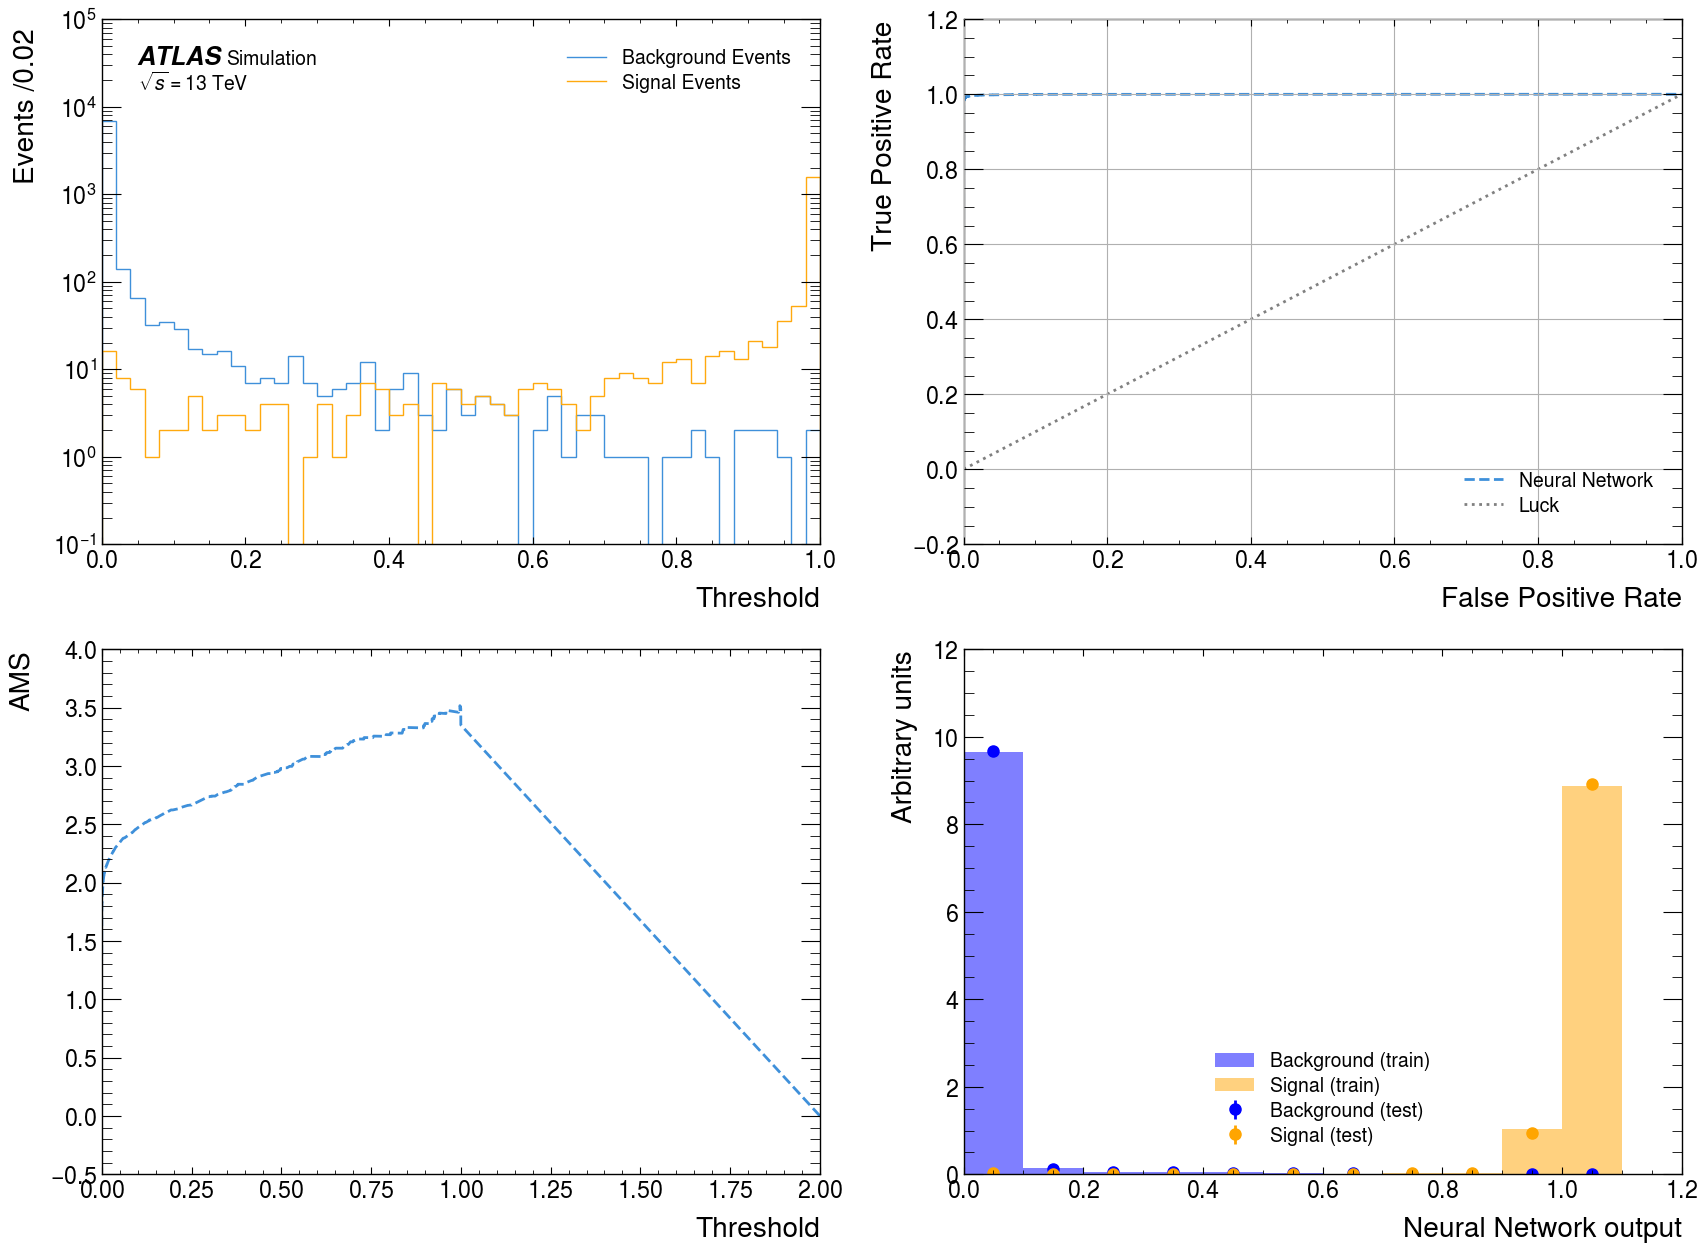

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_full[y_test == 0],decisions_nn_full[y_test == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,1].plot(fpr_nn_full, tpr_nn_full, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_full, ams_nn_full, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_full, X_train_scaled, y_train, X_test_scaled, y_test, "Neural Network output")
plt.show()

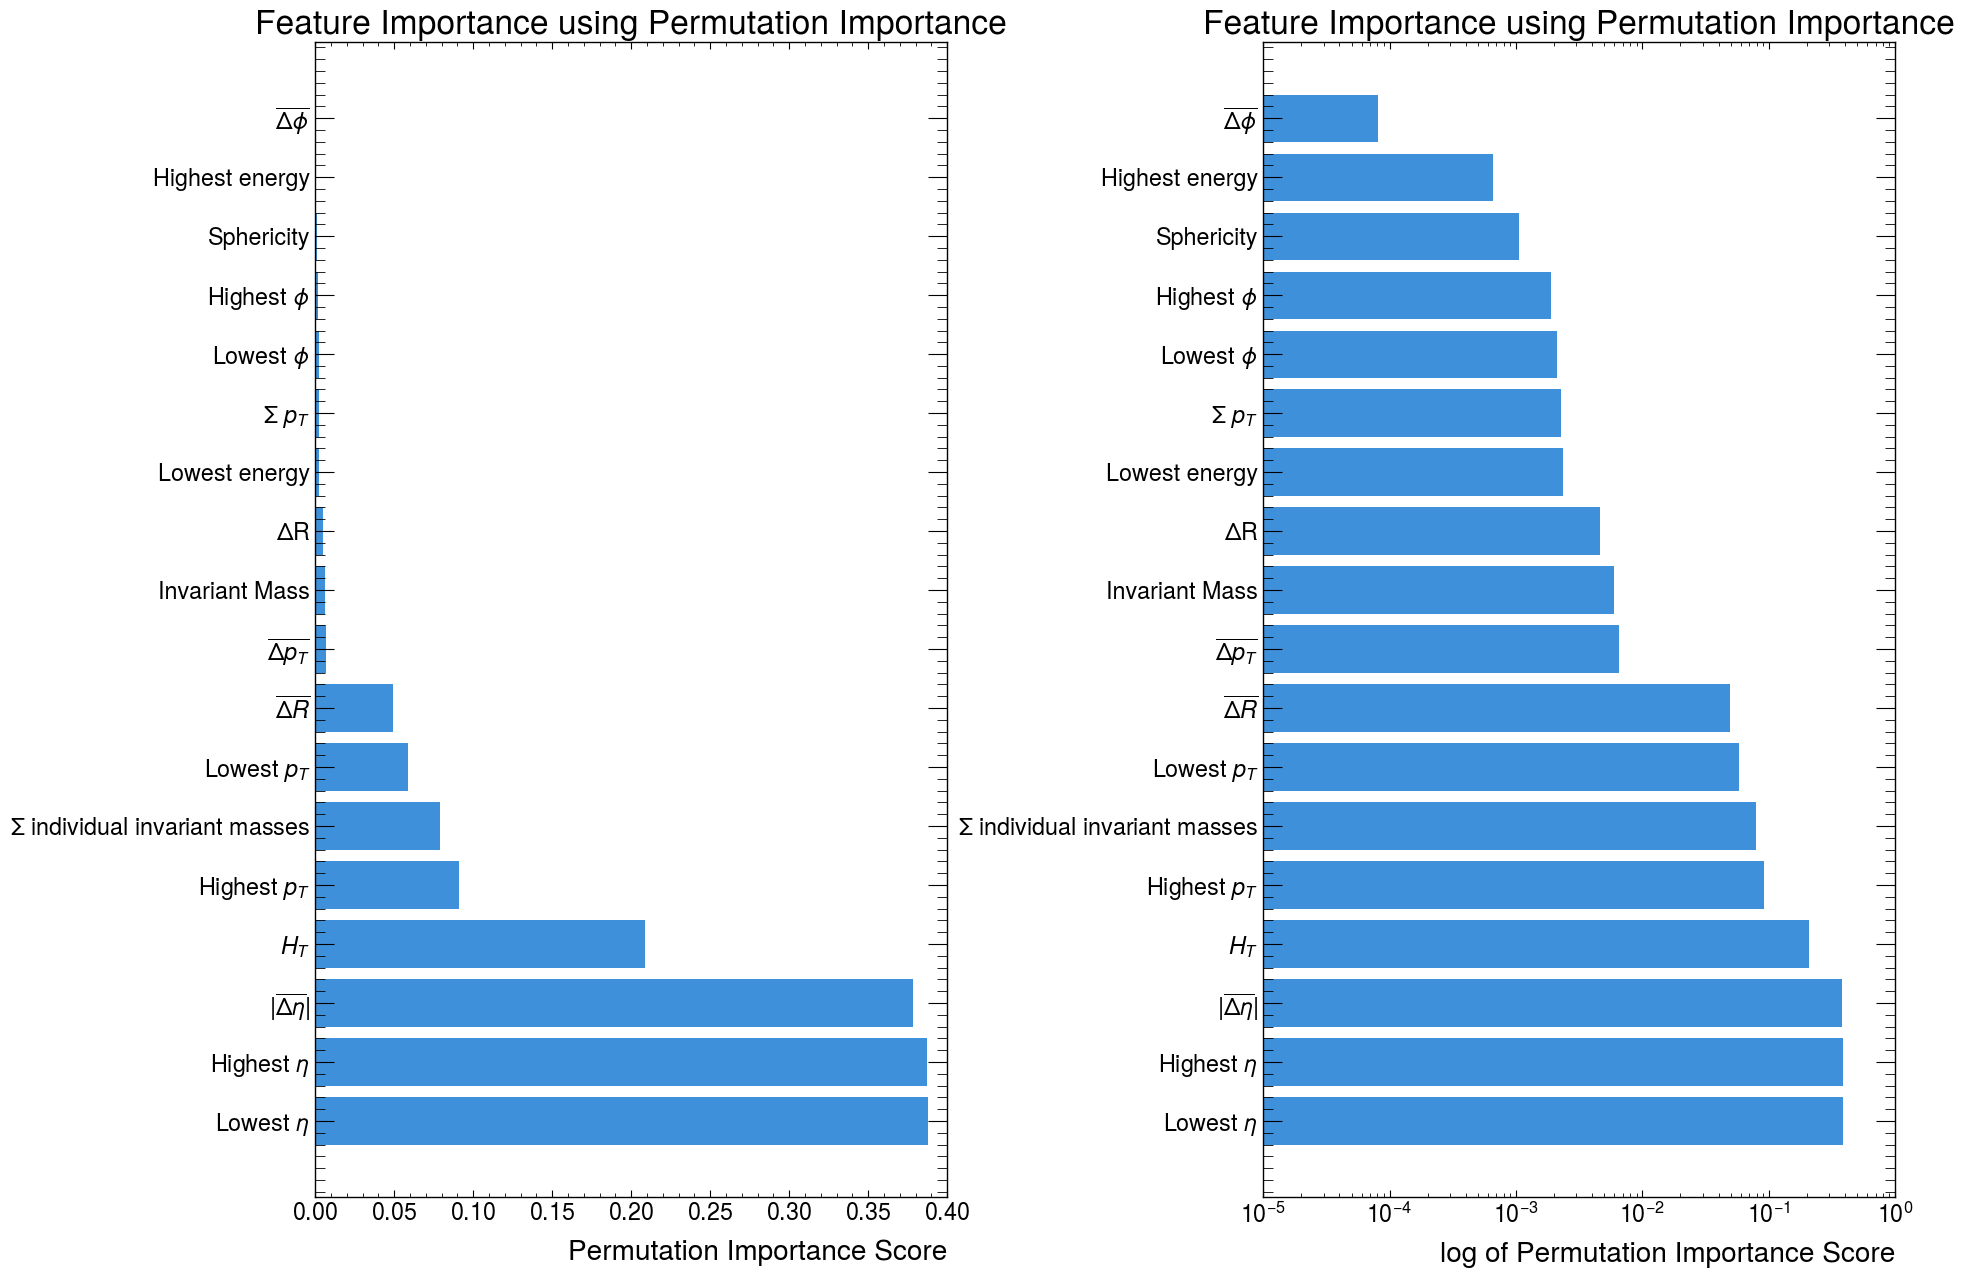

In [ ]:
results = permutation_importance(NN_clf_full, X_test_tensor, y_test_tensor, n_repeats=30, random_state=42)
feature_names = partonic_names_reduced

importance_scores = results.importances_mean

feature_importance = sorted(zip(importance_scores), reverse=True)

sorted_indices = np.argsort(importance_scores)[::-1]

sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names, sorted_importance_scores, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names, sorted_importance_scores, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
X = trans_combined_data_reduced
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)
print(np.shape(X))
print(np.shape(y))

[23803, 21]
(23803,)


In [ ]:
epochs = 20  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = len(X[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 64  # The number of nodes at the first hidden layer
hidden_size2 = 64  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)

X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

In [ ]:
for batch in train_loader:
    x_train_batch, y_train_batch = batch

In [ ]:
class Classifier_MLP_full(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test,y_pred_NN_full)
    
NN_clf_full = Classifier_MLP_full(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf_full.parameters(), lr=learning_rate)

In [ ]:
NN_clf_full.fit(train_loader,valid_loader)

Epoch: 1, Train Loss: 0.363925
Validation Loss: 0.407979, Validation Accuracy: 0.830000
Epoch: 2, Train Loss: 0.350166
Validation Loss: 0.400687, Validation Accuracy: 0.830000
Epoch: 3, Train Loss: 0.348868
Validation Loss: 0.425368, Validation Accuracy: 0.830000
Epoch: 4, Train Loss: 0.347575
Validation Loss: 0.415548, Validation Accuracy: 0.830000
Epoch: 5, Train Loss: 0.346378
Validation Loss: 0.403644, Validation Accuracy: 0.830000
Epoch: 6, Train Loss: 0.345775
Validation Loss: 0.386337, Validation Accuracy: 0.830000
Epoch: 7, Train Loss: 0.343254
Validation Loss: 0.398108, Validation Accuracy: 0.830000
Epoch: 8, Train Loss: 0.342954
Validation Loss: 0.397425, Validation Accuracy: 0.830000
Epoch: 9, Train Loss: 0.344162
Validation Loss: 0.381255, Validation Accuracy: 0.830000
Epoch: 10, Train Loss: 0.340701
Validation Loss: 0.388686, Validation Accuracy: 0.830000
Epoch: 11, Train Loss: 0.342618
Validation Loss: 0.390425, Validation Accuracy: 0.830000
Epoch: 12, Train Loss: 0.34003

In [ ]:
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
out, prob = NN_clf_full(X_test_var)
y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))

decisions_nn_full = (NN_clf_full(X_test_var)[1][:, 1].cpu().detach().numpy())

fpr_nn_full, tpr_nn_full, thresholds_nn_full = roc_curve(y_test, decisions_nn_full)

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001
ams_nn_full = AMS(tpr_nn_full,fpr_nn_full,b_reg)

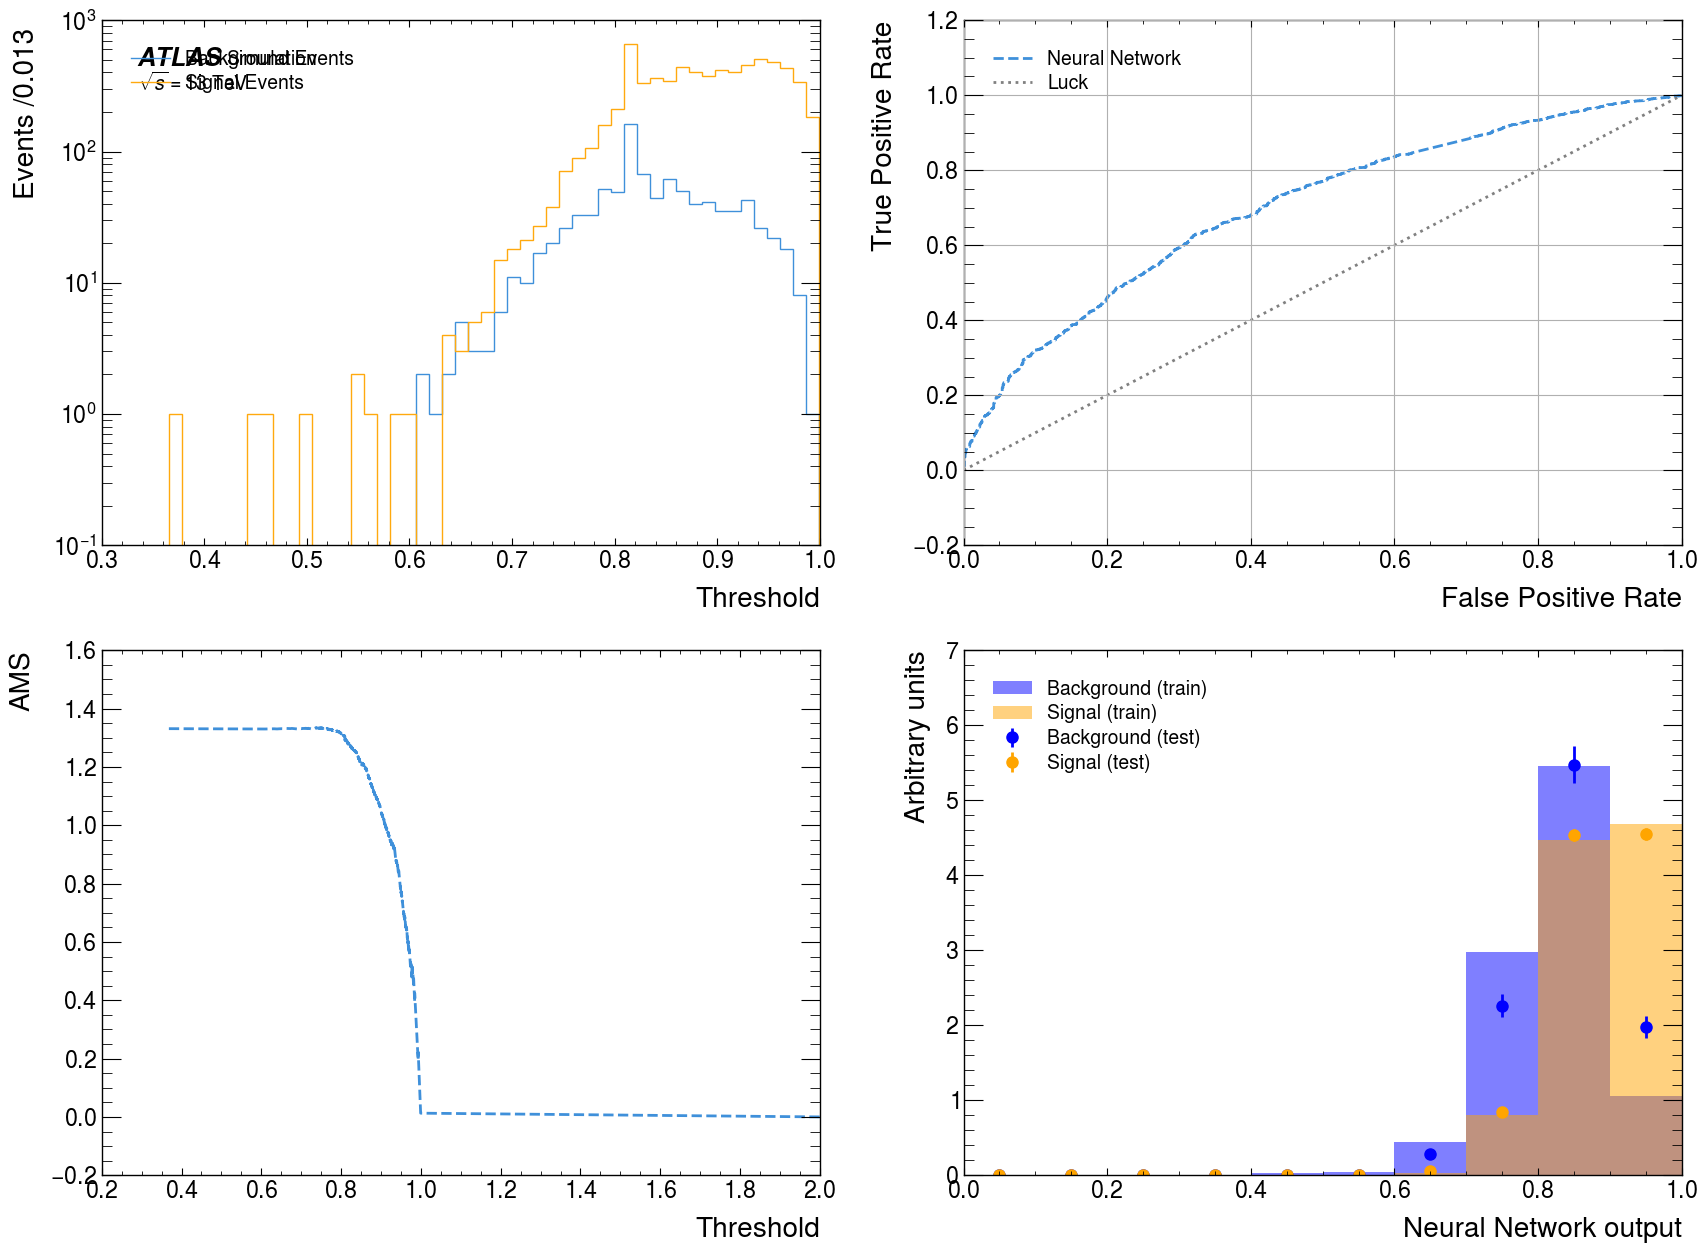

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_full[y_test == 0],decisions_nn_full[y_test == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,1].plot(fpr_nn_full, tpr_nn_full, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_full, ams_nn_full, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_full, X_train_scaled, y_train, X_test_scaled, y_test, "Neural Network output")
plt.show()

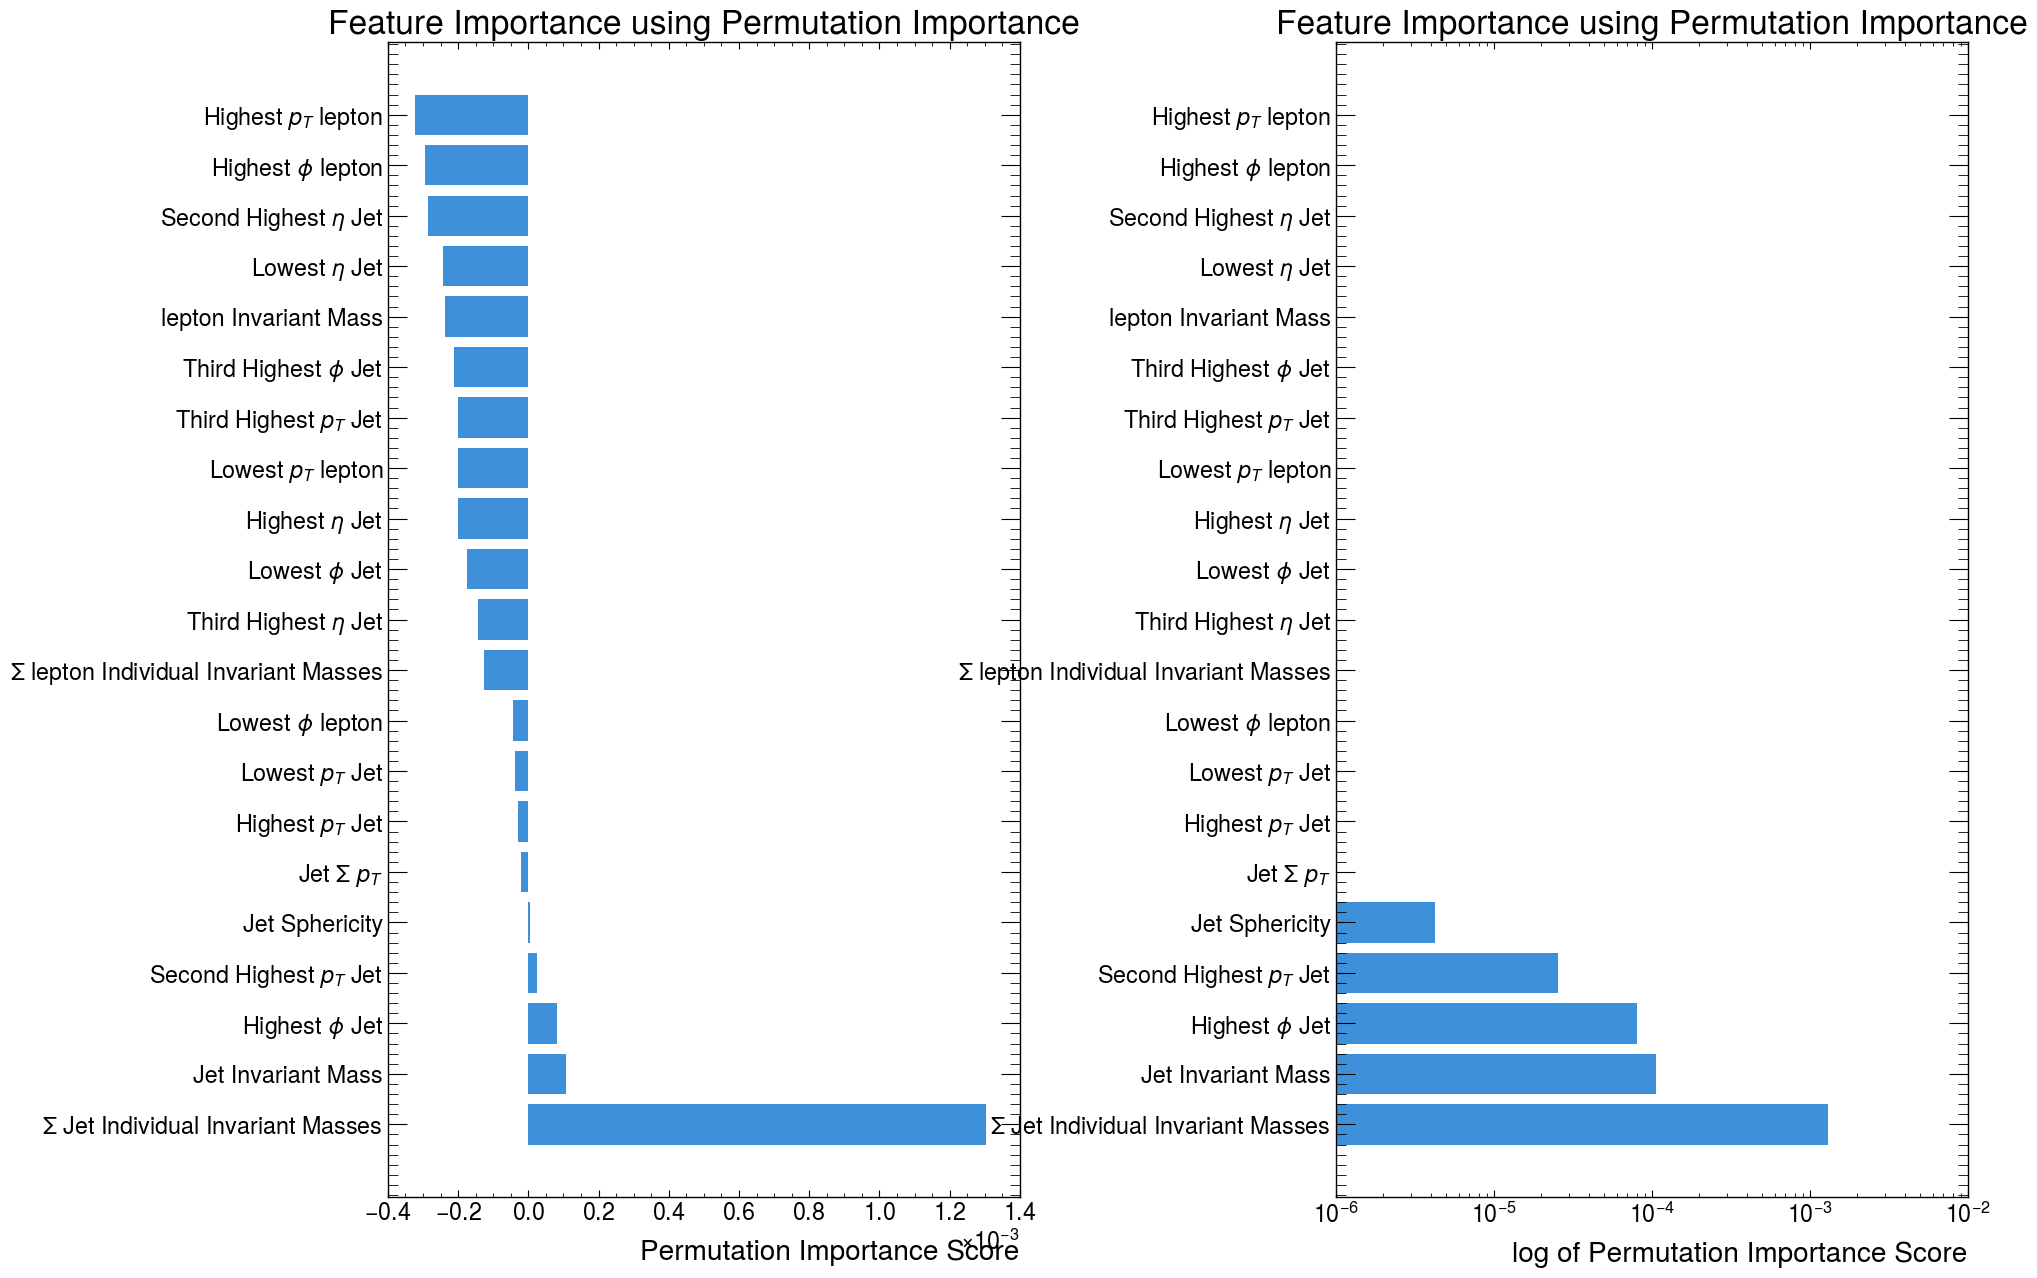

In [ ]:
results = permutation_importance(NN_clf_full, X_test_tensor, y_test_tensor, n_repeats=30, random_state=42)
feature_names = variable_names_reduced

importance_scores = results.importances_mean

feature_importance = sorted(zip(importance_scores), reverse=True)

sorted_indices = np.argsort(importance_scores)[::-1]

sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names, sorted_importance_scores, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names, sorted_importance_scores, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.5)
plt.show()

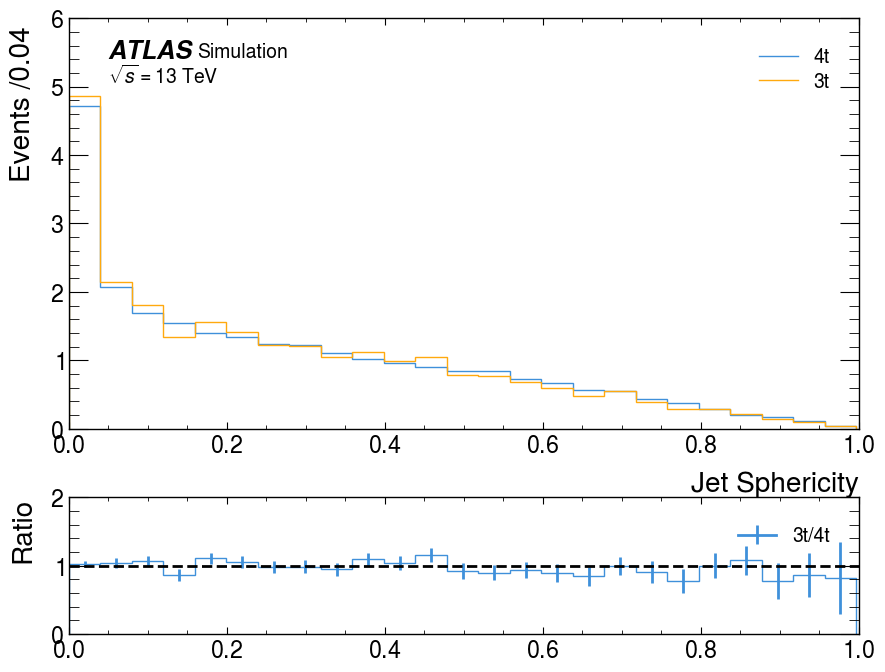

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([sphericity_leptons_4t,sphericity_leptons_3t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Jet Sphericity')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

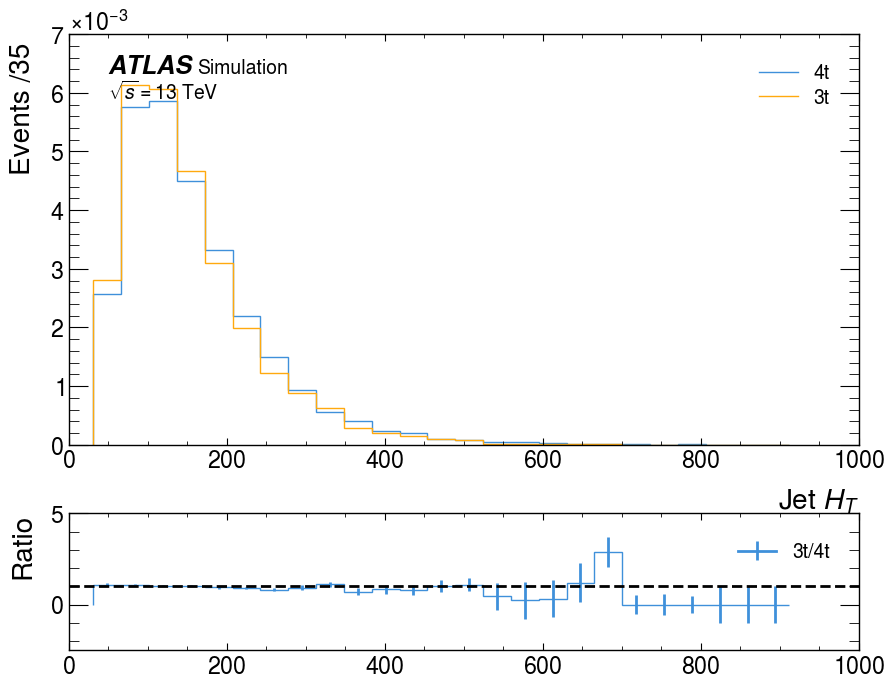

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([leptons_4t_H_t,leptons_3t_H_t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Jet $H_T$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()